In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm, trange

## Task 2.4

Реализуйте новый вариант блекджека на основе окружения BlackjackEnv из OpenAI Gym, в котором разрешено удвоение ставки.

In [2]:
import os
from typing import Optional

import numpy as np

import gym
from gym import spaces
from gym.error import DependencyNotInstalled


def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv(gym.Env):
    """
    Blackjack is a card game where the goal is to beat the dealer by obtaining cards
    that sum to closer to 21 (without going over 21) than the dealers cards.

    ### Description
    Card Values:

    - Face cards (Jack, Queen, King) have a point value of 10.
    - Aces can either count as 11 (called a 'usable ace') or 1.
    - Numerical cards (2-9) have a value equal to their number.

    This game is played with an infinite deck (or with replacement).
    The game starts with the dealer having one face up and one face down card,
    while the player has two face up cards.

    The player can request additional cards (hit, action=1) until they decide to stop (stick, action=0)
    or exceed 21 (bust, immediate loss).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust, the player wins.
    If neither the player nor the dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.

    ### Action Space
    There are two actions: stick (0), and hit (1).

    ### Observation Space
    The observation consists of a 3-tuple containing: the player's current sum,
    the value of the dealer's one showing card (1-10 where 1 is ace),
    and whether the player holds a usable ace (0 or 1).

    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto (http://incompleteideas.net/book/the-book-2nd.html).

    ### Rewards
    - win game: +1
    - lose game: -1
    - draw game: 0
    - win game with natural blackjack:

        +1.5 (if <a href="#nat">natural</a> is True)

        +1 (if <a href="#nat">natural</a> is False)

    ### Arguments

    ```
    gym.make('Blackjack-v1', natural=False, sab=False)
    ```

    <a id="nat">`natural=False`</a>: Whether to give an additional reward for
    starting with a natural blackjack, i.e. starting with an ace and ten (sum is 21).

    <a id="sab">`sab=False`</a>: Whether to follow the exact rules outlined in the book by
    Sutton and Barto. If `sab` is `True`, the keyword argument `natural` will be ignored.
    If the player achieves a natural blackjack and the dealer does not, the player
    will win (i.e. get a reward of +1). The reverse rule does not apply.
    If both the player and the dealer get a natural, it will be a draw (i.e. reward 0).

    ### Version History
    * v0: Initial versions release (1.0.0)
    """

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 4,
    }

    def __init__(self, render_mode: Optional[str] = None, natural=False, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

        self.render_mode = render_mode

    def step(self, action):
        dealer_turn = False
        rate = 1.0
        assert self.action_space.contains(action)
        if action == 2:
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                terminated = True
                reward = -2.0
            else:
                dealer_turn = True
                rate = 2.0
        elif action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                terminated = True
                reward = -1.0
            else:
                terminated = False
                reward = 0.0
        else:
            dealer_turn = True
        if dealer_turn:  # stick: play out the dealers hand, and score
            terminated = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer)) * rate
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = rate
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5

        if self.render_mode == "human":
            self.render()
        return self._get_obs(), reward, terminated, False, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(
        self,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)

        _, dealer_card_value, _ = self._get_obs()

        suits = ["C", "D", "H", "S"]
        self.dealer_top_card_suit = self.np_random.choice(suits)

        if dealer_card_value == 1:
            self.dealer_top_card_value_str = "A"
        elif dealer_card_value == 10:
            self.dealer_top_card_value_str = self.np_random.choice(["J", "Q", "K"])
        else:
            self.dealer_top_card_value_str = str(dealer_card_value)

        if self.render_mode == "human":
            self.render()
        return self._get_obs(), {}

    def render(self):
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[toy_text]`"
            )

        player_sum, dealer_card_value, usable_ace = self._get_obs()
        screen_width, screen_height = 600, 500
        card_img_height = screen_height // 3
        card_img_width = int(card_img_height * 142 / 197)
        spacing = screen_height // 20

        bg_color = (7, 99, 36)
        white = (255, 255, 255)

        if not hasattr(self, "screen"):
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode((screen_width, screen_height))
            else:
                pygame.font.init()
                self.screen = pygame.Surface((screen_width, screen_height))

        if not hasattr(self, "clock"):
            self.clock = pygame.time.Clock()

        self.screen.fill(bg_color)

        def get_image(path):
            cwd = os.path.dirname(__file__)
            image = pygame.image.load(os.path.join(cwd, path))
            return image

        def get_font(path, size):
            cwd = os.path.dirname(__file__)
            font = pygame.font.Font(os.path.join(cwd, path), size)
            return font

        small_font = get_font(
            os.path.join("font", "Minecraft.ttf"), screen_height // 15
        )
        dealer_text = small_font.render(
            "Dealer: " + str(dealer_card_value), True, white
        )
        dealer_text_rect = self.screen.blit(dealer_text, (spacing, spacing))

        def scale_card_img(card_img):
            return pygame.transform.scale(card_img, (card_img_width, card_img_height))

        dealer_card_img = scale_card_img(
            get_image(
                os.path.join(
                    "img",
                    f"{self.dealer_top_card_suit}{self.dealer_top_card_value_str}.png",
                )
            )
        )
        dealer_card_rect = self.screen.blit(
            dealer_card_img,
            (
                screen_width // 2 - card_img_width - spacing // 2,
                dealer_text_rect.bottom + spacing,
            ),
        )

        hidden_card_img = scale_card_img(get_image(os.path.join("img", "Card.png")))
        self.screen.blit(
            hidden_card_img,
            (
                screen_width // 2 + spacing // 2,
                dealer_text_rect.bottom + spacing,
            ),
        )

        player_text = small_font.render("Player", True, white)
        player_text_rect = self.screen.blit(
            player_text, (spacing, dealer_card_rect.bottom + 1.5 * spacing)
        )

        large_font = get_font(os.path.join("font", "Minecraft.ttf"), screen_height // 6)
        player_sum_text = large_font.render(str(player_sum), True, white)
        player_sum_text_rect = self.screen.blit(
            player_sum_text,
            (
                screen_width // 2 - player_sum_text.get_width() // 2,
                player_text_rect.bottom + spacing,
            ),
        )

        if usable_ace:
            usable_ace_text = small_font.render("usable ace", True, white)
            self.screen.blit(
                usable_ace_text,
                (
                    screen_width // 2 - usable_ace_text.get_width() // 2,
                    player_sum_text_rect.bottom + spacing // 2,
                ),
            )
        if self.render_mode == "human":
            pygame.event.pump()
            pygame.display.update()
            self.clock.tick(self.metadata["render_fps"])
        else:
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self):
        if hasattr(self, "screen"):
            import pygame

            pygame.display.quit()
            pygame.quit()

## Task 2.5

Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [4]:
def get_random_V(env):
    space = env.observation_space
    s_shape = space[0].n, space[1].n, space[2].n
    V = np.random.random(s_shape)
    return V.reshape(-1)

def get_random_Q(env):
    space = env.observation_space
    q_shape = space[0].n, space[1].n, space[2].n, env.action_space.n
    Q = np.random.random(q_shape)
    return Q.reshape(-1, env.action_space.n)

def compute_policy_by_Q(env, Q, gamma=1.0):
    return np.argmax(Q, axis=1)

def observation_to_num(observation, env):
    space = env.observation_space
    s_shape = space[0].n, space[1].n, space[2].n
    return observation[0] * space[1].n * space[2].n + observation[1] * space[2].n + int(observation[2])

def Q_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.0, gamma=0.9):
    observation, info = env.reset()
    s_idx = observation_to_num(observation, env)
    s, a = s_idx, pi[s_idx] if np.random.rand() > epsilon else np.random.randint(env.action_space.n)
    for _ in range(1000):
        observation, reward, done, info, _ = env.step(a)
        s_idx = observation_to_num(observation, env)
        s_prime, a_prime = s_idx, pi[s_idx] if np.random.rand() > epsilon else np.random.randint(env.action_space.n)
        Q[s][a] = Q[s][a] + alpha * (reward + gamma * np.max( Q[s_prime] ) - Q[s][a])
        s, a = s_prime, a_prime
        if done:
            break
            
def conduct_experiments_pi(env, pi, num_experiments=1000):
    num_steps, total_reward = [], []
    for _ in range(num_experiments):
        observation, info = env.reset()
        s_idx = observation_to_num(observation, env)
        num_steps.append(0)
        total_reward.append(0)
        for _ in range(1000):
            observation, reward, done, info, _ = env.step(pi[s_idx])
            s_idx = observation_to_num(observation, env)
            total_reward[-1] += reward
            num_steps[-1] += 1
            if done:
                break
    env.close()
    return np.mean(total_reward), np.mean(num_steps)

In [5]:
env = gym.make('Blackjack-v1', natural=False, sab=False)
total_episodes = 15000
gamma = 0.9

# Q_max = compute_Q_max(env, gamma)
# pi_max = compute_policy_by_Q(env, Q_max)

Q_hist_Qlearn = [ ]

Q = get_random_Q(env)
pi = compute_policy_by_Q(env, Q)

for n in range(total_episodes):
    Q_learning_episode(env, pi, Q, alpha=0.1, epsilon= 0.1, gamma=gamma)
    pi = compute_policy_by_Q(env, Q)
    Q_hist_Qlearn.append(np.copy(Q))

env.close()

In [6]:
num_experiments, num_experiments_pi = 1, 100000
total_episodes = 100000
gamma = 0.9

eval_steps = 1000

results_Qlearn = []

Q_arr = [ get_random_Q(env) for _ in range(num_experiments) ]
pi_arr = [ compute_policy_by_Q(env, Q) for Q in Q_arr ]

for n in trange(1, total_episodes+1):
    _ = [ Q_learning_episode(env, pi_arr[i], Q_arr[i], alpha=0.1, epsilon= .1 , gamma=gamma) for i in range(num_experiments) ]
    pi_arr = [ compute_policy_by_Q(env, Q) for Q in Q_arr ]
    if n % eval_steps == 0:
        result = [ conduct_experiments_pi(env, pi, num_experiments=num_experiments_pi) for pi in pi_arr ]
        results_Qlearn.append([ [x[0], x[1]] for x in result ])

env.close()

  0%|          | 0/100000 [00:00<?, ?it/s]

Text(0.5, 0, 'Эпизоды')

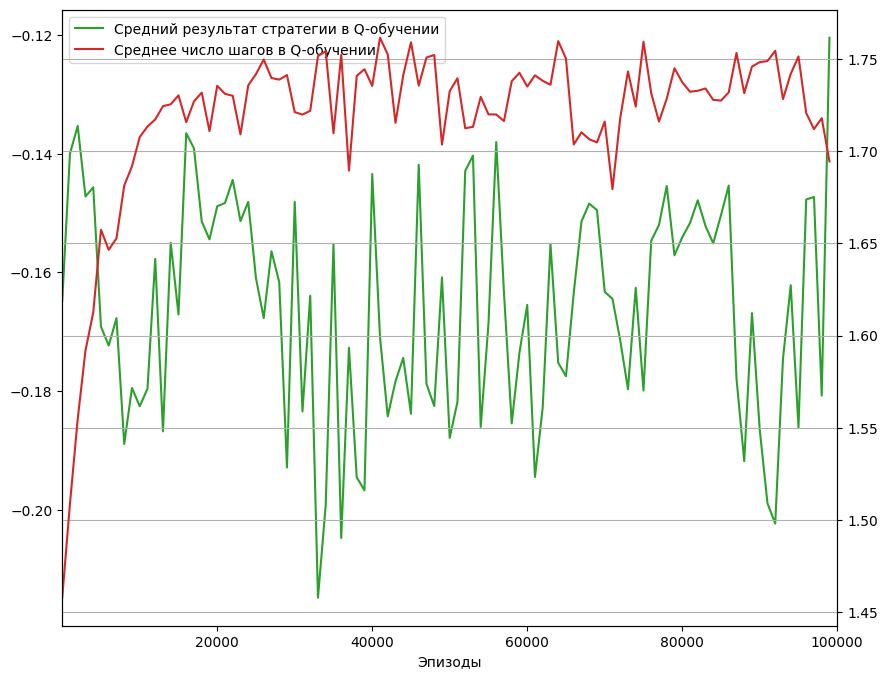

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax2 = ax.twinx()
ax2.grid(None)

avg_returns_Q = np.mean( np.array([ [x[0] for x in res] for res in results_Qlearn]), axis=1)
avg_steps_Q = np.mean( np.array([ [x[1] for x in res] for res in results_Qlearn]), axis=1)

line3 = ax.plot(np.arange(1, total_episodes+1, eval_steps), avg_returns_Q, label="Средний результат стратегии в Q-обучении", color="C2")
line4 = ax2.plot(np.arange(1, total_episodes+1, eval_steps), avg_steps_Q, label="Среднее число шагов в Q-обучении", color="C3")

lines = line3 + line4
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc="upper left")
# ax.set_xlim((0.5, 1.0))
ax.set_xlim((1, total_episodes))
ax.set_xlabel("Эпизоды")